In [1]:

# # IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATASETS
# # TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# # THEN FEEL FREE TO DELETE CELL.

# import os
# import sys
# from tempfile import NamedTemporaryFile
# from urllib.request import urlopen
# from urllib.parse import unquote
# from urllib.error import HTTPError
# from zipfile import ZipFile

# CHUNK_SIZE = 40960
# DATASET_MAPPING = 'g-research-crypto-forecasting:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F30894%2F2815541%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20211106%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20211106T050908Z%26X-Goog-Expires%3D259199%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D58a2921a6fc391bf145619e45ba4345362eebbaf53cbacfaa7e6c1fce5b584bd7e16c098a69a47818ac5dff6313b2c34611d0ab88d3691a0dadf805f8f9c86154c9d95748bb94ba8dcbb421acbd6026201b1e479ec87e71856f50f44c1fbaeaa7ea7ee4ffc4bd79f2d5729695debeb9892b7846c0610359657f508dfe6bdf4c02f8044a78d056181da55feb4bb64e471055f68676cc76426325e76a90f03a558c2afcc3177a2d8e3461c9ae5074f55a963b76d29a9861abba48b8e6565a02fddb5ea561a543771117c92d17dda0f70c40f89b8d4a3a06152cb5f839af56b78b0e5a31f68da6f933623c3417488a692e93671f765e0a2889d379ef4a7873e6ab0'
# KAGGLE_INPUT_PATH='/home/kaggle/input'
# KAGGLE_INPUT_SYMLINK='/kaggle'

# os.makedirs(KAGGLE_INPUT_PATH, 777)
# os.symlink(KAGGLE_INPUT_PATH, os.path.join('..', 'input'), target_is_directory=True)
# os.makedirs(KAGGLE_INPUT_SYMLINK)
# os.symlink(KAGGLE_INPUT_PATH, os.path.join(KAGGLE_INPUT_SYMLINK, 'input'), target_is_directory=True)

# for dataset_mapping in DATASET_MAPPING.split(','):
#     directory, download_url_encoded = dataset_mapping.split(':')
#     download_url = unquote(download_url_encoded)
#     destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
#     try:
#         with urlopen(download_url) as zipfileres, NamedTemporaryFile() as tfile:
#             total_length = zipfileres.headers['content-length']
#             print(f'Downloading {directory}, {total_length} bytes zipped')
#             dl = 0
#             data = zipfileres.read(CHUNK_SIZE)
#             while len(data) > 0:
#                 dl += len(data)
#                 tfile.write(data)
#                 done = int(50 * dl / int(total_length))
#                 sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
#                 sys.stdout.flush()
#                 data = zipfileres.read(CHUNK_SIZE)
#             print(f'\nUnzipping {directory}')
#             with ZipFile(tfile) as zfile:
#                 zfile.extractall(destination_path)
#     except HTTPError as e:
#         print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
#         continue
#     except OSError as e:
#         print(f'Failed to load {download_url} to path {destination_path}')
#         continue
# print('Dataset import complete.')


## GResearch Crypto Forecasting
### Introduction
In this competition you will forecast the prices of several cyrptoassets. Once you make that prediction, you can move on to the next batch and will get additional data.

This competition is different from most Kaggle Competitions in that:
* You can only submit from Kaggle Notebooks
* You must use our custom `gresearch_crypto` Python module.  The purpose of this module is to control the flow of information to ensure that you are not using future data to make predictions.  If you do not use this module properly, your code may fail.

### This starter notebook demonstrates how to use the `gresearch_crypto` module to get the test features and make predictions.
### TL;DR: End-to-End Usage Example
```
import gresearch_crypto
env = gresearch_crypto.make_env()

# Training data is in the competition dataset as usual
train_df = pd.read_csv('/kaggle/input/g-research-crypto-forecasting/train.csv', low_memory=False)
tgt_1_model.fit(train_df)
tgt_2_model.fit(train_df)
iter_test = env.iter_test()
for (test_df, sample_prediction_df) in iter_test:
    sample_prediction_df['Target'] = tgt_1_model.predict(test_df)
    env.predict(sample_prediction_df)
```
Note that `tgt_1_model.fit` and `tgt_2_model.fit` are examples of the functions you need to write for the above example to work.

### Introduction
First let's import the module and create an environment. Adding the directory holding the module to the pythonpath with `sys.path.append` isn't strictly necessary within Kaggle notebooks, which handles that behind the scenes, but will be necessary if you are testing your code offline.

In [2]:
# %pip install pytorch-forecasting

In [3]:
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch
import pytorch_lightning as pl

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [4]:
# import gresearch_crypto

In [5]:
import pandas as pd
import numpy as np
from scipy.ndimage.interpolation import shift

In [6]:
train_df_o = pd.read_csv('../input/g-research-crypto-forecasting/train.csv', low_memory=False, 
                       dtype={'Asset_ID': 'int8', 'Count': 'int32', 'row_id': 'int32', 'Count': 'int32', 
                              'Open': 'float64', 'High': 'float64', 'Low': 'float64', 'Close': 'float64', 
                              'Volume': 'float64', 'VWAP': 'float64'
                             }
                      )

crypto_weights = pd.read_csv('../input/g-research-crypto-forecasting/asset_details.csv')

In [7]:
def reindex_by_date(df):
    dates = range(df.index[0], df.index[-1]+60,60)
    return df.reindex(dates)

In [8]:
def log_returns_crypto(price):
    return np.log(price.shift(periods=-16,fill_value=np.nan) / price.shift(periods=-1,fill_value=np.nan))

In [9]:
def dataframe_roll(df):
    if df.index[0]+3750*60 in df.index:
        return np.mean(df[:df.index[0]+3750*60])
    else: 
        return np.nan

This forecasting competition aims to predict returns in the near future for prices $P^a$, for each asset $a$. For each row in the dataset, we include the target for prediction, `Target`. `Target` is derived from log returns ($R^a$) over 15 minutes.

$$R^a(t) = log (P^a(t+16)\ /\ P^a(t+1))$$

Crypto asset returns are highly correlated, following to a large extend the overall crypto market. As we want to test your ability to predict returns for individual assets, we perform a linear residualization, removing the market signal from individual asset returns when creating the target. In more detail, if $M(t)$ is the weighted average market returns, the target is:

$$M(t) = \frac{\sum_a w^a R^a(t)}{\sum_a w^a}$$
$$\beta^a = \frac{\langle M \cdot R^a \rangle}{\langle M^2 \rangle}$$
$$\text{Target}^a(t) = R^a(t) - \beta^a M(t)$$

where the bracket $\langle .\rangle$ represent the rolling average over time (3750 minute windows), and same asset weights $w^a$ used for the evaluation metric.

Some rows have null values for targets due to missing values in future prices. Rows with nulls in the test set ground truth are ignored for scoring purposes.

In [10]:
def generate_target(train_df, crypto_weights):
    train_df = train_df.sort_values('timestamp').set_index("timestamp")
    
    train_df = train_df.groupby('Asset_ID').apply(reindex_by_date).iloc[:,1:].reset_index()
    
    train_df['log_returns'] = train_df.groupby('Asset_ID')['VWAP'].apply(log_returns_crypto)
        
    train_df = train_df.set_index('Asset_ID').join(crypto_weights.set_index('Asset_ID'))
    
    train_df['weighted_avg_returns'] = train_df['log_returns']*train_df['Weight']
    wamr = train_df.reset_index().groupby('timestamp')[['Weight','weighted_avg_returns']].sum()
    wamr['wamr'] = wamr['weighted_avg_returns']/wamr['Weight']
    
    train_df = train_df.iloc[:,:-1].reset_index().set_index('timestamp').join(wamr[['weighted_avg_returns','wamr']])
    train_df['wamr_log_returns'] = train_df['wamr']*train_df['log_returns']
    train_df['wamr_squared'] = train_df['wamr']*train_df['wamr']
    
    # indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=3750)
    rolling_avg = train_df.sort_values(['Asset_ID','timestamp']).groupby('Asset_ID')[['wamr_log_returns','wamr_squared']].rolling(3750).mean()
    rolling_avg['beta'] = rolling_avg['wamr_log_returns'] / rolling_avg['wamr_squared']
    
    train_df = train_df.iloc[:,:-2].reset_index().set_index(['Asset_ID','timestamp']).join(rolling_avg)
    train_df['target_manual'] = train_df['log_returns'] - ([0 if np.isnan(beta) else beta for beta in train_df['beta']] * train_df['wamr'])
    
    return(train_df)

In [23]:
train_df = train_df_o.set_index('Asset_ID').join(crypto_weights.set_index('Asset_ID'))
train_df = train_df.sort_values('timestamp').reset_index().set_index("timestamp")

train_df = train_df.groupby('Asset_ID').apply(reindex_by_date).iloc[:,1:].reset_index()

train_df['log_returns'] = train_df.groupby('Asset_ID')['VWAP'].apply(log_returns_crypto)

train_df['weighted_avg_returns'] = train_df['log_returns']*train_df['Weight']
wamr = train_df.reset_index().groupby('timestamp')[['Weight','weighted_avg_returns']].sum()
wamr['wamr'] = wamr['weighted_avg_returns']/wamr['Weight']

train_df = train_df.iloc[:,:-1].reset_index().set_index('timestamp').join(wamr[['weighted_avg_returns','wamr']])
train_df['wamr_log_returns'] = train_df['wamr']*train_df['log_returns']
train_df['wamr_squared'] = train_df['wamr']*train_df['wamr']

/opt/conda/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [24]:
train_df = train_df.reset_index()
train_df['timestamp_dt'] = train_df.timestamp.astype('datetime64[s]')
train_df = train_df.set_index('timestamp_dt')

rolling_avg = train_df[['Asset_ID','wamr_squared']].groupby('Asset_ID').rolling('3750min').mean()

rolling_cov = train_df[['Asset_ID','wamr','log_returns']].groupby('Asset_ID').rolling('3750min').cov()
rolling_cov = rolling_cov.reset_index()

train_df = train_df.reset_index().sort_values(['Asset_ID','timestamp_dt'])
train_df['wamr_log_returns_rolling'] = rolling_cov[rolling_cov['level_2']=='wamr'].log_returns.values
train_df['wamr_squared_rolling'] = rolling_avg.wamr_squared.values

In [25]:
train_df['beta'] = train_df['wamr_log_returns_rolling'] / train_df['wamr_squared_rolling']
train_df['target_manual'] = train_df['log_returns'] - (train_df['beta'] * train_df['wamr'])
train_df

,timestamp_dt,timestamp,index,Asset_ID,Count,Open,High,Low,Close,Volume,...,Asset_Name,log_returns,weighted_avg_returns,wamr,wamr_log_returns,wamr_squared,wamr_log_returns_rolling,wamr_squared_rolling,beta,target_manual
0,2018-01-01 00:01:00,1514764860,0,0,5.0,8.530000,8.530000,8.530000,8.530000,7.838000e+01,...,Binance Coin,-0.014195,-0.246034,-0.009163,0.000130,0.000084,NaN,0.000084,NaN,NaN
8,2018-01-01 00:02:00,1514764920,1,0,7.0,8.530000,8.530000,8.514500,8.514500,7.139000e+01,...,Binance Coin,-0.014021,-0.331611,-0.012351,0.000173,0.000153,-2.769543e-07,0.000118,-0.002342,-0.014050
16,2018-01-01 00:03:00,1514764980,2,0,45.0,8.506500,8.529900,8.484800,8.484800,1.546820e+03,...,Binance Coin,-0.015055,-0.267185,-0.009951,0.000150,0.000099,-3.929865e-07,0.000112,-0.003514,-0.015090
24,2018-01-01 00:04:00,1514765040,3,0,14.0,8.500900,8.506600,8.474400,8.500900,1.258000e+02,...,Binance Coin,-0.012880,-0.245145,-0.009130,0.000118,0.000083,2.619999e-07,0.000105,0.002502,-0.012858
32,2018-01-01 00:05:00,1514765100,4,0,5.0,8.500700,8.500700,8.456000,8.456000,1.250100e+02,...,Binance Coin,-0.004563,-0.180511,-0.006723,0.000031,0.000045,6.688200e-06,0.000093,0.072055,-0.004079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26079986,2021-09-20 23:56:00,1632182160,26080038,13,477.0,0.091435,0.091500,0.091120,0.091221,2.613704e+06,...,TRON,NaN,0.000000,0.000000,NaN,0.000000,2.580180e-05,0.000024,1.083139,NaN
26080000,2021-09-20 23:57:00,1632182220,26080039,13,980.0,0.091130,0.091195,0.090802,0.090863,4.991573e+06,...,TRON,NaN,0.000000,0.000000,NaN,0.000000,2.580625e-05,0.000024,1.083408,NaN
26080014,2021-09-20 23:58:00,1632182280,26080040,13,720.0,0.090853,0.090940,0.090740,0.090859,3.699102e+06,...,TRON,NaN,0.000000,0.000000,NaN,0.000000,2.581215e-05,0.000024,1.083684,NaN
26080028,2021-09-20 23:59:00,1632182340,26080041,13,686.0,0.090941,0.091450,0.090860,0.091326,3.241507e+06,...,TRON,NaN,0.000000,0.000000,NaN,0.000000,2.581719e-05,0.000024,1.083942,NaN


In [28]:
train_df_2 = train_df[(~train_df.target_manual.isna()) & (~np.isinf(train_df['target_manual']))]

In [29]:
np.sum(np.abs(train_df_2['Target'] - train_df_2['target_manual']))

30425.486465092592

In [30]:
train_df_2[['Target','target_manual']]

,Target,target_manual
8,-0.015875,-0.014050
16,-0.015410,-0.015090
24,-0.012524,-0.012858
32,-0.005940,-0.004079
40,-0.005455,-0.002410
...,...,...
26079762,0.000199,-0.000821
26079776,-0.003477,-0.002162
26079790,-0.002437,-0.001841
26079804,0.004843,-0.001936


In [26]:
train_df = generate_target(train_df_o,crypto_weights)

In [31]:
tdf = train_df.reset_index()
tdf[(tdf['timestamp']>1600000000) & (tdf['Asset_Name']=='Monero') & (tdf['target_manual'].isna()) &
   (~tdf['Open'].isna()) & (~tdf['Target'].isna())].head(50)

,level_0,timestamp_dt,timestamp,index,Asset_ID,Count,Open,High,Low,Close,...,Asset_Name,log_returns,weighted_avg_returns,wamr,wamr_log_returns,wamr_squared,wamr_log_returns_rolling,wamr_squared_rolling,beta,target_manual
21775714,18923016,2020-09-30 23:44:00,1601509440,21775714,11,56.0,107.985000,108.10,107.89,107.960000,...,Monero,NaN,0.0,0.0,NaN,0.0,0.000006,0.000006,1.015601,NaN
21775729,18923226,2020-09-30 23:59:00,1601510340,21775729,11,68.0,108.366667,108.66,108.26,108.556667,...,Monero,NaN,0.0,0.0,NaN,0.0,0.000006,0.000006,1.017877,NaN
21820354,19547976,2020-10-31 23:44:00,1604187840,21820354,11,26.0,126.130000,126.39,126.06,126.200000,...,Monero,NaN,0.0,0.0,NaN,0.0,0.000009,0.000008,1.146623,NaN
21820369,19548186,2020-10-31 23:59:00,1604188740,21820369,11,18.0,126.520000,126.53,126.47,126.520000,...,Monero,NaN,0.0,0.0,NaN,0.0,0.000009,0.000008,1.145920,NaN
21863554,20152776,2020-11-30 23:44:00,1606779840,21863554,11,24.0,129.833333,129.88,129.69,129.823333,...,Monero,NaN,0.0,0.0,NaN,0.0,0.000018,0.000021,0.879971,NaN
21863569,20152986,2020-11-30 23:59:00,1606780740,21863569,11,340.0,130.010000,130.78,130.00,130.480000,...,Monero,NaN,0.0,0.0,NaN,0.0,0.000018,0.000021,0.876442,NaN
21908194,20777736,2020-12-31 23:44:00,1609458240,21908194,11,15.0,156.355000,156.38,156.24,156.255000,...,Monero,NaN,0.0,0.0,NaN,0.0,0.000011,0.000016,0.684886,NaN
21908209,20777946,2020-12-31 23:59:00,1609459140,21908209,11,17.0,156.245000,156.25,156.07,156.150000,...,Monero,NaN,0.0,0.0,NaN,0.0,0.000011,0.000016,0.682553,NaN
21952834,21402696,2021-01-31 23:44:00,1612136640,21952834,11,78.0,138.073333,138.30,137.98,138.073333,...,Monero,NaN,0.0,0.0,NaN,0.0,0.000016,0.000041,0.389893,NaN
21952849,21402906,2021-01-31 23:59:00,1612137540,21952849,11,17.0,137.823333,137.87,137.65,137.770000,...,Monero,NaN,0.0,0.0,NaN,0.0,0.000016,0.000041,0.388993,NaN


In [32]:
tdf[(tdf['timestamp']>=1601509440) & (tdf['Asset_Name']=='Monero')].head(50).wamr_log_returns

21775714             NaN
21775715    6.011260e-06
21775716    5.443975e-06
21775717    7.764035e-06
21775718    2.389212e-05
21775719    2.230577e-05
21775720    2.950656e-05
21775721    1.939422e-05
21775722    1.727463e-05
21775723    1.009925e-05
21775724    9.014892e-07
21775725   -4.580140e-07
21775726    1.672077e-06
21775727    4.352239e-06
21775728   -9.870951e-07
21775729             NaN
21775731   -4.907630e-07
21775732    2.980944e-06
21775733    1.353535e-06
21775734    1.138469e-06
21775735    4.937243e-07
21775736   -4.087143e-06
21775737   -4.685633e-07
21775738    4.591060e-07
21775739    5.735528e-07
21775740    4.598676e-06
21775741    1.830955e-07
21775742   -4.784196e-07
21775743   -1.038856e-07
21775744    1.840474e-06
21775745    2.437405e-06
21775746    1.487281e-05
21775747    9.683181e-06
21775748   -1.700371e-06
21775749   -4.927723e-07
21775750   -4.928491e-06
21775751   -5.042376e-06
21775752   -2.169790e-06
21775753   -1.393353e-06
21775754   -1.009403e-06


In [33]:
train_df = train_df.reset_index()
train_df = train_df[(~train_df.VWAP.isna()) & (~np.isinf(train_df['VWAP']))]
train_df

,level_0,Asset_ID,timestamp,Count,Open,High,Low,Close,Volume,VWAP,...,log_returns,Weight,Asset_Name,weighted_avg_returns,wamr,wamr_log_returns,wamr_squared,beta,target_manual,index
0,0,0,1514764860,5,8.530000,8.530000,8.530000,8.530000,7.838000e+01,8.530000,...,-0.014195,4.304065,Binance Coin,-0.260627,-0.009707,NaN,NaN,NaN,-0.014195,25246081
1,1,1,1514764860,229,13835.194000,14013.800000,13666.110000,13850.176000,3.155006e+01,13827.062093,...,-0.014566,6.779922,Bitcoin,-0.260627,-0.009707,NaN,NaN,NaN,-0.014566,25246081
2,2,2,1514764860,40,2376.580000,2399.500000,2357.140000,2374.590000,1.923301e+01,2373.116392,...,-0.004086,2.397895,Bitcoin Cash,-0.260627,-0.009707,NaN,NaN,NaN,-0.004086,25246081
3,3,5,1514764860,32,7.659600,7.659600,7.656700,7.657600,6.626713e+03,7.657713,...,-0.014027,1.386294,EOS.IO,-0.260627,-0.009707,NaN,NaN,NaN,-0.014027,25246081
4,4,6,1514764860,173,738.302500,746.000000,732.510000,738.507500,3.359879e+02,738.839291,...,-0.004555,5.894403,Ethereum,-0.260627,-0.009707,NaN,NaN,NaN,-0.004555,25246081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26079563,26079814,9,1632181440,163,156.502000,156.620000,156.000000,156.075667,7.381963e+02,156.260253,...,0.006093,2.397895,Litecoin,0.302610,0.007402,0.000024,0.000024,0.991499,-0.001247,27203024
26079564,26079815,10,1632181440,23,2420.146667,2421.000000,2412.779000,2414.069667,1.315794e+00,2417.326038,...,0.009565,1.098612,Maker,0.302610,0.007402,0.000026,0.000024,1.083228,0.001546,27203024
26079565,26079816,11,1632181440,38,232.075000,232.300000,231.310000,231.680000,4.914804e+01,231.794078,...,0.003830,1.609438,Monero,0.302610,0.007402,0.000023,0.000024,0.955083,-0.003240,27203024
26079566,26079817,12,1632181440,193,0.280952,0.281300,0.280175,0.280403,1.628699e+05,0.280655,...,0.006957,2.079442,Stellar,0.302610,0.007402,0.000023,0.000024,0.946173,-0.000047,27203024


In [34]:
# define dataset
max_encoder_length = 16*7
max_prediction_length = 16
training_cutoff = train_df.timestamp.max() - 16*60  # day for cutoff

In [35]:
# train_df = train_df.reset_index()
train_df['index'] = (train_df['timestamp']/60).astype('int')
train_df

,level_0,Asset_ID,timestamp,Count,Open,High,Low,Close,Volume,VWAP,...,log_returns,Weight,Asset_Name,weighted_avg_returns,wamr,wamr_log_returns,wamr_squared,beta,target_manual,index
0,0,0,1514764860,5,8.530000,8.530000,8.530000,8.530000,7.838000e+01,8.530000,...,-0.014195,4.304065,Binance Coin,-0.260627,-0.009707,NaN,NaN,NaN,-0.014195,25246081
1,1,1,1514764860,229,13835.194000,14013.800000,13666.110000,13850.176000,3.155006e+01,13827.062093,...,-0.014566,6.779922,Bitcoin,-0.260627,-0.009707,NaN,NaN,NaN,-0.014566,25246081
2,2,2,1514764860,40,2376.580000,2399.500000,2357.140000,2374.590000,1.923301e+01,2373.116392,...,-0.004086,2.397895,Bitcoin Cash,-0.260627,-0.009707,NaN,NaN,NaN,-0.004086,25246081
3,3,5,1514764860,32,7.659600,7.659600,7.656700,7.657600,6.626713e+03,7.657713,...,-0.014027,1.386294,EOS.IO,-0.260627,-0.009707,NaN,NaN,NaN,-0.014027,25246081
4,4,6,1514764860,173,738.302500,746.000000,732.510000,738.507500,3.359879e+02,738.839291,...,-0.004555,5.894403,Ethereum,-0.260627,-0.009707,NaN,NaN,NaN,-0.004555,25246081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26079563,26079814,9,1632181440,163,156.502000,156.620000,156.000000,156.075667,7.381963e+02,156.260253,...,0.006093,2.397895,Litecoin,0.302610,0.007402,0.000024,0.000024,0.991499,-0.001247,27203024
26079564,26079815,10,1632181440,23,2420.146667,2421.000000,2412.779000,2414.069667,1.315794e+00,2417.326038,...,0.009565,1.098612,Maker,0.302610,0.007402,0.000026,0.000024,1.083228,0.001546,27203024
26079565,26079816,11,1632181440,38,232.075000,232.300000,231.310000,231.680000,4.914804e+01,231.794078,...,0.003830,1.609438,Monero,0.302610,0.007402,0.000023,0.000024,0.955083,-0.003240,27203024
26079566,26079817,12,1632181440,193,0.280952,0.281300,0.280175,0.280403,1.628699e+05,0.280655,...,0.006957,2.079442,Stellar,0.302610,0.007402,0.000023,0.000024,0.946173,-0.000047,27203024


In [36]:
norm = GroupNormalizer(groups=['Asset_ID'], transformation="softplus",center=True, eps=1.0)

training = TimeSeriesDataSet(
    train_df[lambda x: x.timestamp < training_cutoff],
    time_idx= 'index',
    target= 'VWAP',
    # weight="weight",
    group_ids=['Asset_ID'],
    target_normalizer=norm,
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=['Asset_ID'],
    static_reals=[],
    time_varying_known_categoricals=[],
    time_varying_known_reals=[],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=['Count','Open','High','Low','Close','Volume'],
    allow_missing_timesteps=True,
    add_relative_time_idx=True,
    add_target_scales=True,
)

In [37]:
# create validation and training dataset
validation = TimeSeriesDataSet.from_dataset(training, train_df, min_prediction_idx=training.index.time.max() + 1, stop_randomization=True)
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=2)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=2)

In [38]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

11.720526695251465

In [41]:
# configure network and trainer
pl.seed_everything(43)
trainer = pl.Trainer(
    gpus=1,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 20.3k


/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:819: LightningDeprecationWarning: `trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
  "`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6."
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of th

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

suggested learning rate: 6.918309709189363e-06


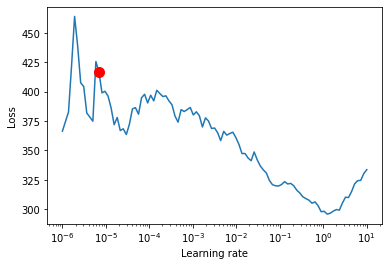

In [42]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [43]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=20, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=1,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=1000,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.001,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 20.3k


In [44]:
# fit network
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:532: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  "`trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6."


Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [45]:
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=5,
    max_epochs=25,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

[I 2021-11-06 14:45:44,816] A new study created in memory with name: no-name-4f30e051-65d1-4fb9-8ef6-4962f2f0f813
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory optuna_test/trial_0 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:532: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  "`trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6."
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this mach

OSError: [Errno 12] Cannot allocate memory

In [49]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [55]:
import gc
gc.collect()

9179

In [56]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(137.7245)

In [57]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

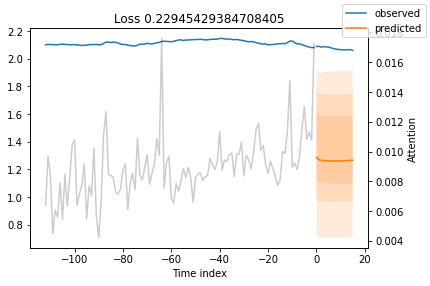

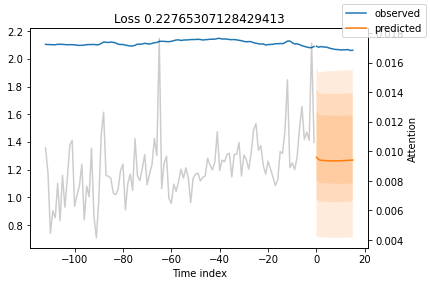

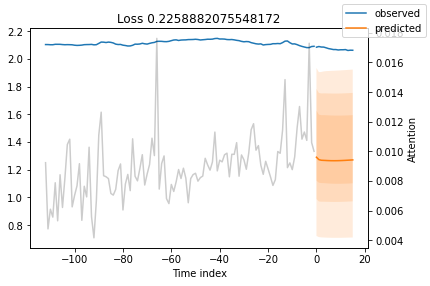

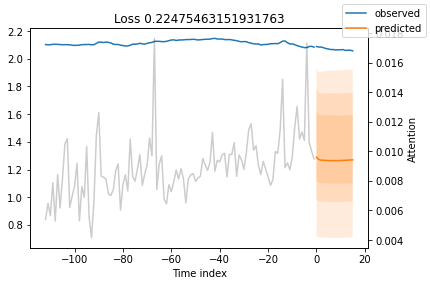

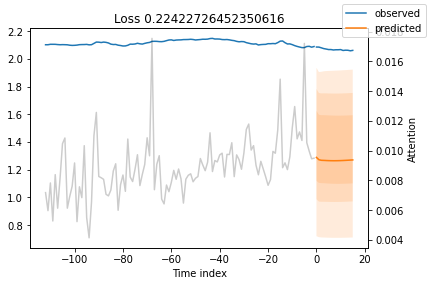

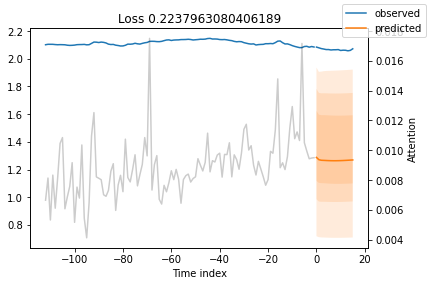

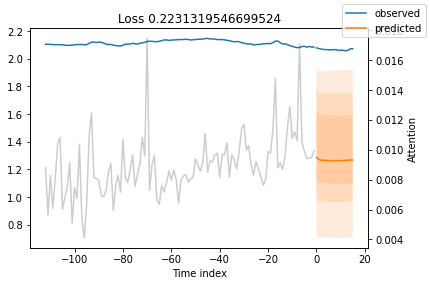

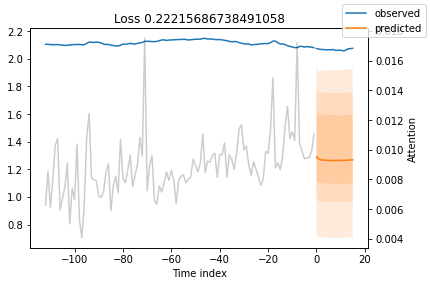

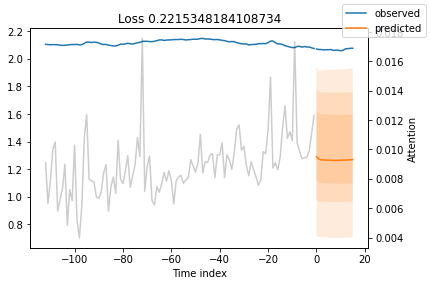

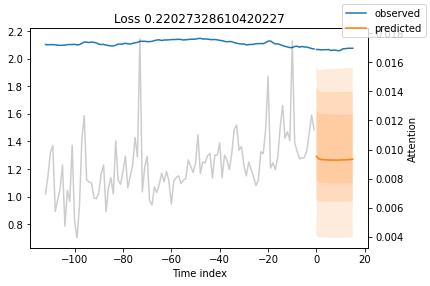

In [58]:
for idx in range(500,510):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

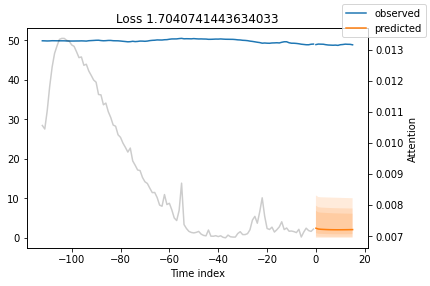

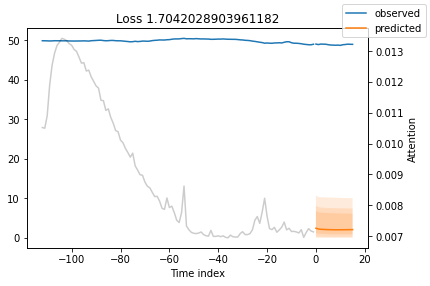

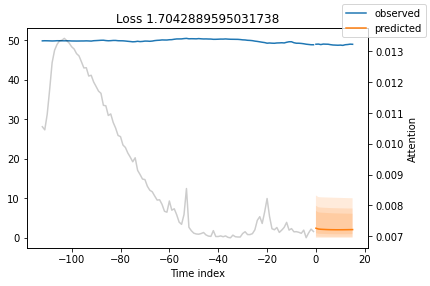

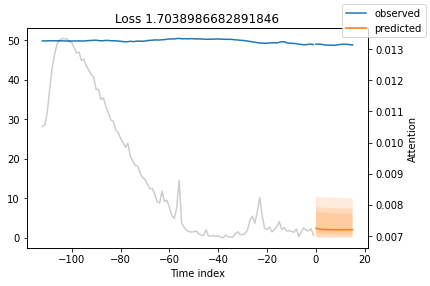

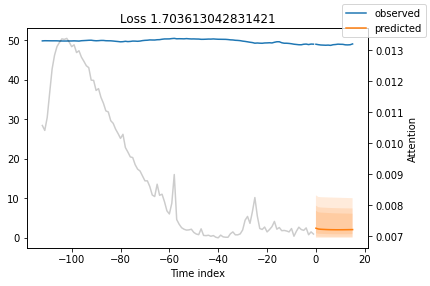

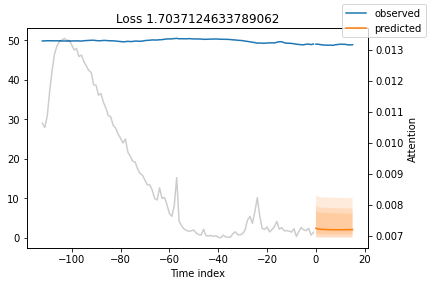

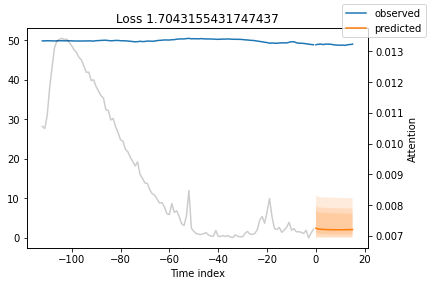

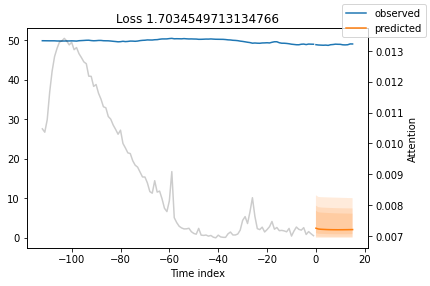

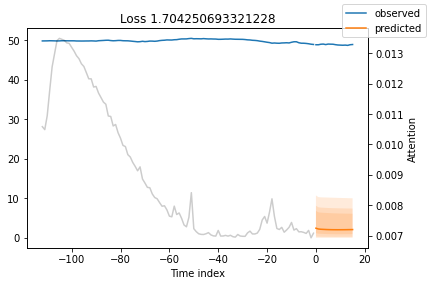

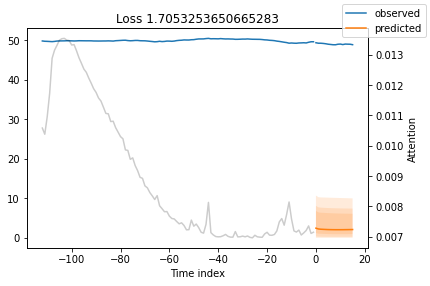

In [59]:
# calcualte metric by which to display
predictions = best_tft.predict(val_dataloader)
mean_losses = SMAPE(reduction="none")(predictions, actuals).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(
        x, raw_predictions, idx=indices[idx], add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles)
    );

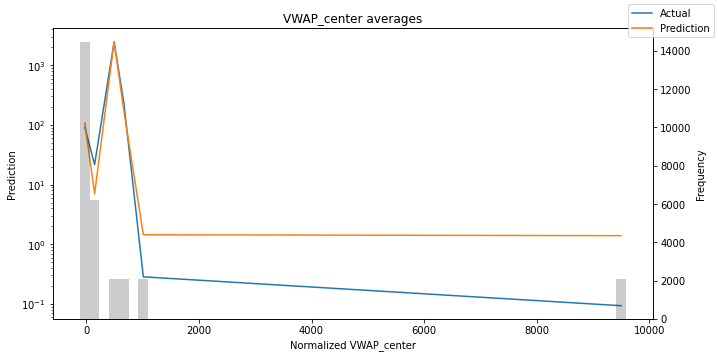

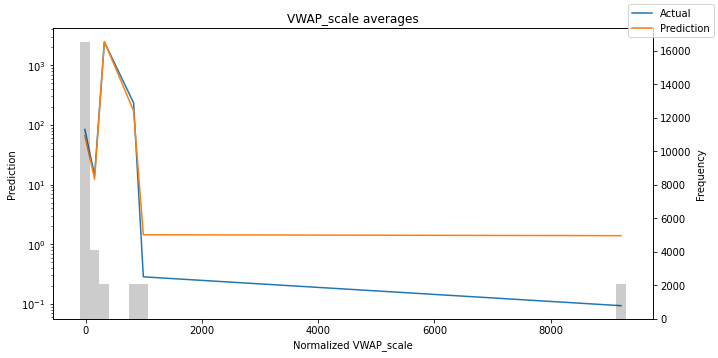

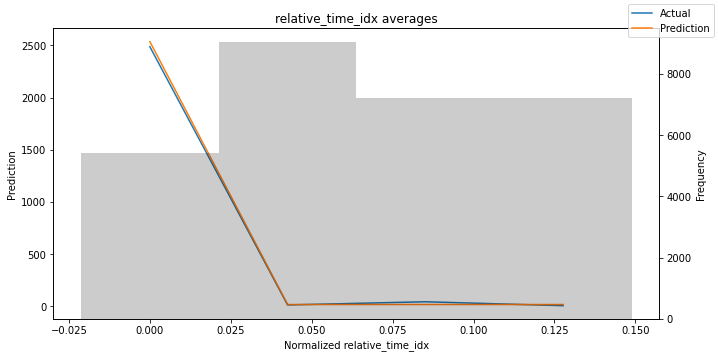

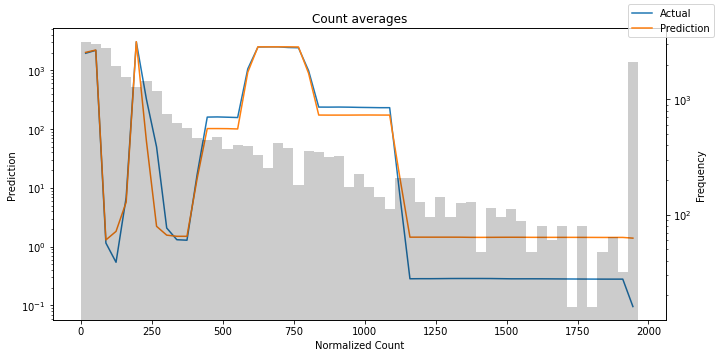

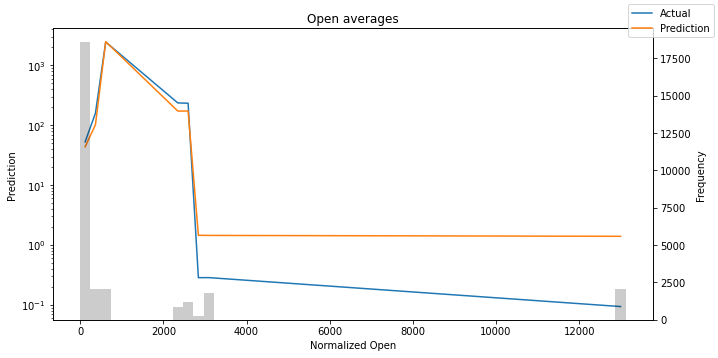

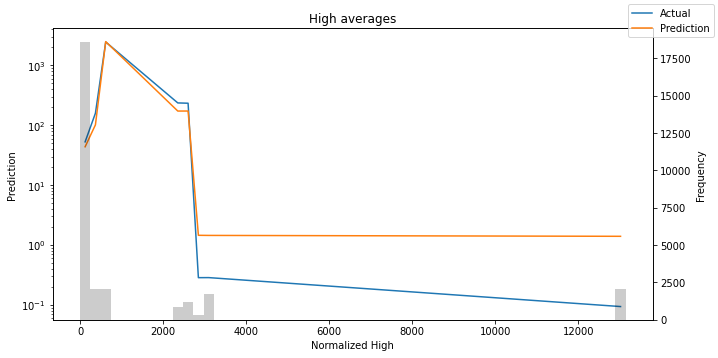

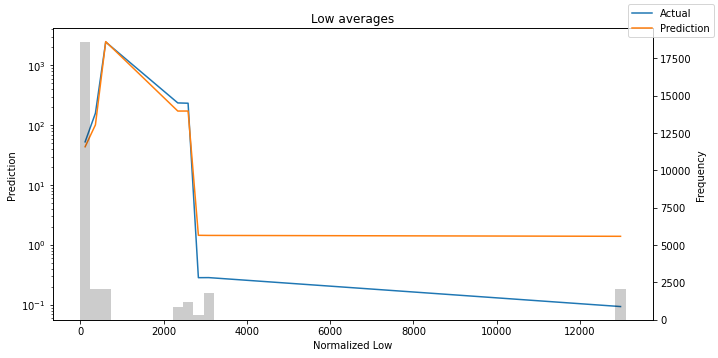

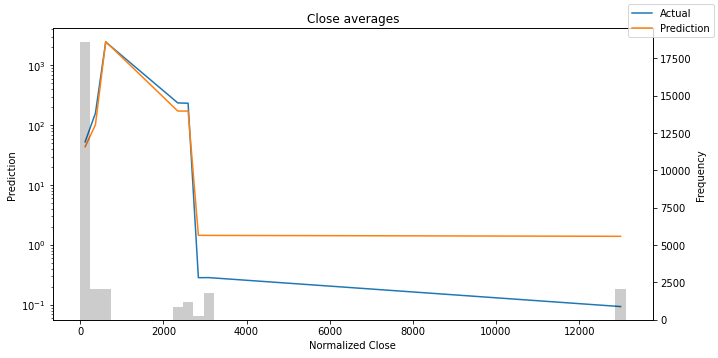

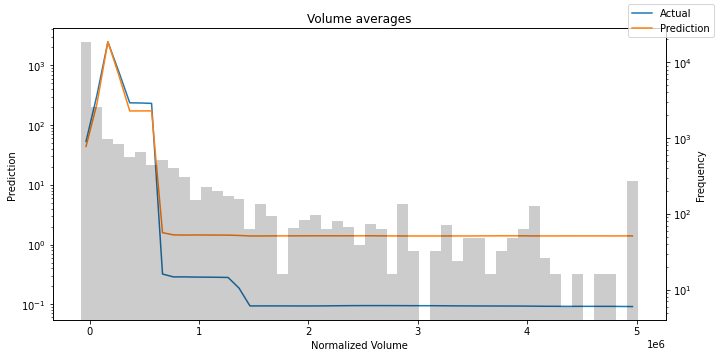

In [60]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

{'attention': <Figure size 432x288 with 1 Axes>,
 'static_variables': <Figure size 504x180 with 1 Axes>,
 'encoder_variables': <Figure size 504x270 with 1 Axes>,
 'decoder_variables': <Figure size 504x162 with 1 Axes>}

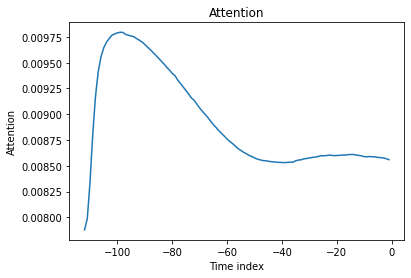

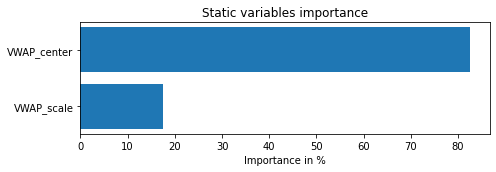

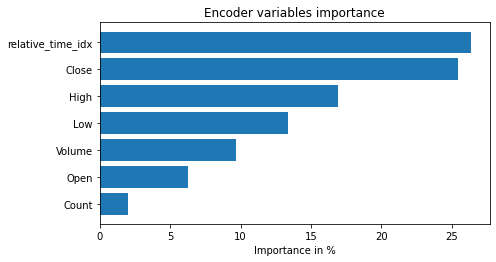

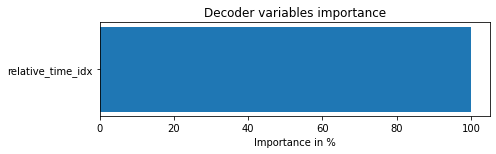

In [61]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)

In [62]:
test_df = pd.read_csv('../input/g-research-crypto-forecasting/example_test.csv', low_memory=False, 
                       dtype={'Asset_ID': 'int8', 'Count': 'int32', 'row_id': 'int32', 'Count': 'int32', 
                              'Open': 'float64', 'High': 'float64', 'Low': 'float64', 'Close': 'float64', 
                              'Volume': 'float64', 'VWAP': 'float64', 'group_num' : 'int32', 'row_id' : 'int32'
                             }
                      )

In [63]:
test_df['index'] = (test_df['timestamp']/60).astype('int')
test_df

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,group_num,row_id,index
0,1623542400,3,1201,1.478556,1.486030,1.478000,1.483681,6.547996e+05,1.481439,0,0,27059040
1,1623542400,2,1020,580.306667,583.890000,579.910000,582.276667,1.227988e+03,581.697038,0,1,27059040
2,1623542400,0,626,343.789500,345.108000,343.640000,344.598000,1.718833e+03,344.441729,0,2,27059040
3,1623542400,1,2888,35554.289632,35652.464650,35502.670000,35602.004286,1.638115e+02,35583.469303,0,3,27059040
4,1623542400,4,433,0.312167,0.312600,0.311920,0.312208,5.855774e+05,0.312154,0,4,27059040
5,1623542400,5,359,4.832550,4.845900,4.822900,4.837583,4.714355e+04,4.836607,0,5,27059040
6,1623542400,7,541,55.223080,55.494000,55.182000,55.344680,6.625202e+03,55.298816,0,6,27059040
7,1623542400,6,2186,2371.194286,2379.200000,2369.670000,2374.380714,1.214129e+03,2374.335307,0,7,27059040
8,1623542400,8,35,1.003150,1.019800,0.987300,1.003300,7.061928e+03,1.002936,0,8,27059040
9,1623542400,9,560,161.933429,162.480000,161.730000,162.214714,1.485009e+03,162.231310,0,9,27059040


You can only call make_env() **once**, so don't lose it!

In [ ]:
env = gresearch_crypto.make_env()

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

### `iter_test` function

This is a generator which loops through each timestamp in the test set. You have direct access to the example test rows for your convenience, but your code will only be able to get rows from the real test set via the API. Once you call `predict` you can continue on to the next batch.

Yields:
* While there are more batch(es) and `predict` was called successfully since the last yield, yields a tuple of:
    * `test_df`: DataFrame with the test features for the next batch, and user responses for the previous batch.
    * `sample_prediction_df`: DataFrame with an example prediction.  Intended to be filled in and passed back to the `predict` function.
* If `predict` has not been called successfully since the last yield, prints an error and yields `None`.

In [ ]:
# You can only iterate through a result from `env.iter_test()` once
# so be careful not to lose it once you start iterating.
iter_test = env.iter_test()

Let's get the data for the first test batch and check it out.

In [ ]:
(test_df, sample_prediction_df) = next(iter_test)
test_df.head(3)

Note the warning about the lack of optimization! The version of the API that will deliver the hidden test set is both more efficient and going to deliver substantially more data. It's highly recommended that you read to [the data page](https://www.kaggle.com/c/g-research-crypto-forecasting/data) timeseries section for a discussion of how to plan for the impact of the API on your notebook's runtime and memory use.

In [ ]:
sample_prediction_df.head(3)

We'll get an error if we try to continue on to the next batch without making our predictions for the current batch.

In [ ]:
next(iter_test)

### **`predict`** function
Stores your predictions for the current batch.  Expects the same format as `sample_prediction_df`.

Args:
* `predictions_df`: DataFrame which must have the same format as `sample_prediction_df`.

This function will raise an Exception if not called after a successful iteration of the `iter_test` generator.

Let's make a dummy prediction using the sample provided by `iter_test`.

In [ ]:
env.predict(sample_prediction_df)

### Main Loop
Let's loop through all the remaining batches in the test set generator and make the default prediction for each.  The `iter_test` generator will simply stop returning values once you've reached the end.

When writing your own notebooks, be sure to write robust code that makes as few assumptions about the `iter_test`/`predict` loop as possible.  For example there may be large gaps between timestamps for one or more cryptoassets. In the unlikely event that a cryptoasset were dropped from enough exchanges it might go missing from the dataset entirely.

You may assume that the structure of `sample_prediction_df` will not change in this competition.

In [ ]:
for (test_df, sample_prediction_df) in iter_test:
    sample_prediction_df['Target'] = 0
    env.predict(sample_prediction_df)

### Restart the Notebook to run your code again
In order to combat cheating you are only allowed to call `make_env` or iterate through `iter_test` once per Notebook run.  However, while you're iterating on your model it's reasonable to try something out, change the model a bit, and try it again.  Unfortunately, if you try to simply re-run the code, or even refresh the browser page, you'll still be running on the same Notebook execution session you had been running before, and the `gresearch_crypto` module will still throw errors.  To get around this you need to explicitly restart your Notebook execution session.